# SC Project 1 

In [31]:
import numpy as np
import numpy.linalg as la
from watermatrices import Amat, Bmat, yvec
import seaborn as sns
from numpy import newaxis as na
import matplotlib.pyplot as plt

# 3 Week 1 Questions

# a) Computing the condition number
$\mathrm{cond_{\infty}(M) = ||M||_\infty||M^{-1}||_\infty}$

In [2]:
def inf_norm(M): 
    """Computes the max norm of a matrix M."""
    return np.max(np.sum(np.abs(M),axis = 1))
def condition(M): 
    """Returns condition number of a matrix M."""
    return inf_norm(M)*inf_norm(np.linalg.inv(M))

In [32]:
omega = np.array([0.800, 1.146, 1.400])
n = np.shape(Amat)[0]
I = np.identity(n)
Zmat = np.zeros((n,n))
E = np.block([[Amat,Bmat],[Bmat,Amat]])
S = np.block([[I,Zmat],[Zmat,-I]])
z = np.concatenate((yvec,-yvec))
CondM = np.empty(shape=(3,)) 
M = np.empty(shape=(3,*np.shape(E)))
for i in range(3):
    M[i] = E-omega[i]*S
    CondM[i] = condition(M[i]) 
print("Condition numbers: {},\nNumber of lost digits: {}".format(CondM, np.log10(CondM))) #condition number for the given frequencies

Condition numbers: [   327.81670424 152679.26875234    227.19443667],
Number of lost digits: [2.51563108 5.18378007 2.35639769]


# b) Bound for relative error
$\frac{||\Delta x||_\infty}{||x||_\infty} \le \mathrm{cond_{\infty}(E-\omega S)}\cdot 
\frac{||\delta \omega S||_\infty}{||E-\omega S||_\infty}$

In [46]:
dw = 1/2*1e-3
Bound = np.empty(shape=(3,))
for i in range(3):
    Bound[i] = CondM[i]*inf_norm(dw*S)/inf_norm(M[i])
print("Relative Error Bounds: {:3.4f},{:3.2f},{:3.4f}".format(*Bound))

Relative Error Bounds: 0.0052,2.41,0.0036


# c) Solving systems of linear equations with LU factorization

## 1.

In [16]:
def lu_factorize(A):
    """Performs matrix decomposition A=LU where L is lower triangular and 
    U is upper triangular. Returns L and U."""
    n = A.shape[0]
    U = np.zeros((n, n), dtype=np.double)
    L = np.eye(n, dtype=np.double)
    for k in range(n):
        U[k, k:] = A[k, k:] - L[k,:k].dot(U[:k,k:])
        L[(k+1):,k] = (A[(k+1):,k] - L[(k+1):,:].dot(U[:,k]))/ U[k, k]
    return L, U

## 2.

In [190]:
def forward_substitute(L,z):
    """Takes lower triangular matrix L and vector z and return y, such that
    Ly=z."""
    n = len(z)
    y = np.zeros((n,))
    y[0] = z[0]
    for i in np.arange(1,n):
        y[i] = z[i]-L[i,:].dot(y) 
    return y

## 3. 

In [191]:
def back_substitute(U,y):
    """"Takes upper triangular matrix U and vector y and performs back substitution 
    returning x, such that Ux = y."""
    n = len(y)
    x = np.zeros((n,))
    for i in np.arange(n-1,-1,-1):
        x[i] = (y[i]-U[i,:].dot(x))/U[i,i]
    return x

## Test 

In [19]:
def solve_linear(A,b):
    """Returns solutions x to the linear system Ax=b, by using LU factorization."""
    L,U = lu_factorize(A)
    y = forward_substitute(L,b)
    x = back_substitute(U,y)
    return x

In [65]:
M_test0 = np.array([[2,1,1],[4,1,4],[-6,-5,3]])
b_test0 = np.array([4,11,4])
x_test0 = solve_linear(M_test0,b_test0)
x_np = la.solve(M_test0,b_test0)
print("Computed solution: {}".format(x_test0)) #testing the algorithm against a numpy routine
print('x_custom-x_numpy = {}'.format(x_test0-x_np)) 

Computed solution: [-4.  7.  5.]
x_custom-x_numpy = [-3.10862447e-15  4.44089210e-15  1.77635684e-15]


## d. Calculating $\alpha$ 

In [68]:
def solve_alpha(omega):
    x = solve_linear(E-omega*S,z)
    return (z.T)@x
alpha = np.empty(shape=(3))
for i in range(3):
    alpha[i] = solve_alpha(omega[i])
print("alpha = {}".format(alpha))

alpha = [ 1.63613813e+00  2.60923532e+03 -2.70689266e+00]


### (1) 

|$\omega$|$\alpha$|
|--------|--------|
|0.800|$1.636\pm0.005$|
|1.146|$2609.2\pm2.5$|
|1.400|$-2.708\pm0.004$|

## e. Computing table of $\alpha(\omega)$ 

In [114]:
v_omega = np.linspace(0.7,1.5,1000)
v_alpha = np.empty(shape=(v_omega.shape[0]))
for i in range(len(v_omega)):
    v_alpha[i] = solve_alpha(v_omega[i])
omega_sing = 1.146307999
alpha_sing = solve_alpha(omega_sing)
condition_sing = condition(E-omega_sing*S)
print("alpha(omega_sing) = {:3.2e}, cond(M(omega_sing)) = {:3.2e}".format(alpha_sing, condition_sing))

alpha(omega_sing) = 1.79e+09, cond(M(omega_sing)) = 1.05e+11


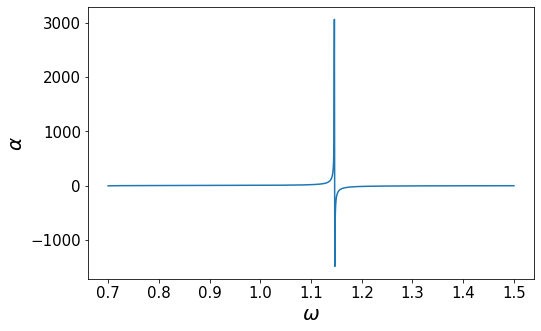

In [163]:
fig, ax = plt.subplots(figsize=(8,5))
ax = sns.lineplot(v_omega, v_alpha, ax = ax)
ax.set_xlabel(r'$\omega$', fontsize = 20),ax.set_ylabel(r'$\alpha$', fontsize =20)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.show()
fig.savefig("alpha_omega.pdf", bbox_inches = 'tight')

# 4 Week 2 Questions

## f. Implementation of QR and LSQ 

In [115]:
I = np.eye(3)
B = np.array([[-1,1,0],[-1,0,1],[0,-1,1]])
A_test = np.block([[I],[B]])
b_test = np.array([1237,1941,2417,711,1177,475])

In [116]:
def householder_QR(A):
    """Takes mxn matrix A with m>=n and performs QR decomposition."""
    m,n = A.shape
    R = np.copy(A)
    Q = np.eye(m)
    for k in range(n):
            v = np.copy(R[k:,k])
            alpha = -np.copysign(1,v[0])*la.norm(v,2)
            v[0] -= alpha
            beta = la.norm(v,2)
            if beta==0:
                continue
            v /= beta
            R[k:,k:] = R[k:,k:]-2*v[:,na]*tp(v).dot(R[k:,k:])
            Q[k:,:] = Q[k:,:]-2*v[:,na]*tp(v).dot(Q[k:,:])
    return  Q.T,R
#Check QR decomposition
Q_test,R_test=householder_QR(A_test)
I_test0 =Q_test@Q_test.T
I_test1 = Q_test.T@Q_test
devI0 = la.norm((I_test0-np.eye(I_test0.shape[0])),2)
devI1 = la.norm((I_test1-np.eye(I_test1.shape[0])),2)
dev = la.norm((A_test-Q_test@R_test),2)
dev, devI0, devI1

(1.40090968311115e-15, 1.0256394125759673e-15, 1.0277948414258594e-15)

In [117]:
def householder_fast(A):
    """Fast version of QR decomposition, where Q is not computed. The Householder 
    vectors are stored in matrix V=[v1,v2,...,vn]."""
    m,n = A.shape
    R = np.copy(A)
    V = np.zeros((m,n))
    for k in range(n):
            v = np.copy(R[k:,k])
            alpha = -np.copysign(1,v[0])*la.norm(v,2)
            v[0] -= alpha
            beta = la.norm(v,2)
            if beta==0:
                continue
            v /= beta
            V[k:,k] = v 
            R[k:,k:] = R[k:,k:]-2*v[:,na]*tp(v).dot(R[k:,k:])
    return V, R

In [118]:
#Transoforming right hand side of Ax=b
def apply_projection(V,b0):
    """Takes matrix V=[v1, v2, ..., vn] which contains the Householder vectors 
    and applies the projection n times to vector b."""
    _,n = V.shape
    b = np.copy(b0)
    for k in range(n):
        v = V[k:,k]
        b[k:] =b[k:]- 2*v@b[k:]*v
    return b

In [122]:
def lsq(A,b):
    """Returns least squares solution to the system Ax=b using Householder QR decomposition."""
    _,n = A.shape
    V, R = householder_fast(A)
    Hb = apply_projection(V,b)
    x = back_substitute(R[:n],Hb[:n])
    return x

x_test = lsq(A_test, b_test)
print(x_test)

[1236.1810056  1942.5853051  2415.47676453]


In [142]:
#Choose boundaries for LSQ
bound = [0.7, 1.12]
omega_mask = (v_omega>bound[0])&(v_omega<bound[1])
v_omega_new = v_omega[omega_mask]
v_alpha_new = v_alpha[omega_mask]

In [148]:
def compute_coefficients_P(v_alpha,v_omega,n):
    """Computes the coefficients for the polynomial sum(a_i*omega**(2*i))."""
    exponents = np.arange(0,n*2+2,2)
    Omega = v_omega[:,na]**exponents
    return lsq(Omega, v_alpha)

def Poly(v_omega,a_coeff,n):
    """Computes polynomial sum(a[i]*omega**(2*i))"""
    exponent = np.arange(0,n*2+2,2)
    Omega = v_omega[:,na]**exponent
    return Omega@a_coeff

In [144]:
a_coeff_4 = compute_coefficients_P(v_alpha_new,v_omega_new, 10)
P_alpha_4 = Poly(v_omega_new, a_coeff_4, 10)
dalpha4 = (P_alpha_4-v_alpha_new)/v_alpha_new
a_coeff_6 = compute_coefficients_P(v_alpha_new,v_omega_new, 6)
P_alpha_6 = Poly(v_omega_new,a_coeff_6, 6)
dalpha6 = (P_alpha_6-v_alpha_new)/v_alpha_new

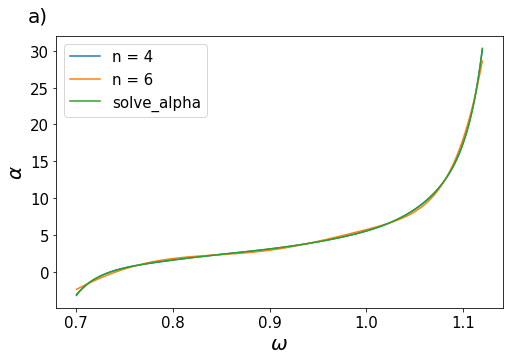

In [185]:
fig, ax = plt.subplots(figsize=(8,5))
ax = sns.lineplot(v_omega_new, P_alpha_4,label = 'n = 4')
ax = sns.lineplot(v_omega_new, P_alpha_6, label = 'n = 6')
ax = sns.lineplot(v_omega_new, v_alpha_new, label = 'solve_alpha')
ax.set_xlabel(r'$\omega$', fontsize = 20),ax.set_ylabel(r'$\alpha$', fontsize =20)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend(fontsize = 15)
ax.text(0.65,34,'a)',fontsize= 20)
plt.show()
fig.savefig("Polynomial.pdf", bbox_inches = 'tight')

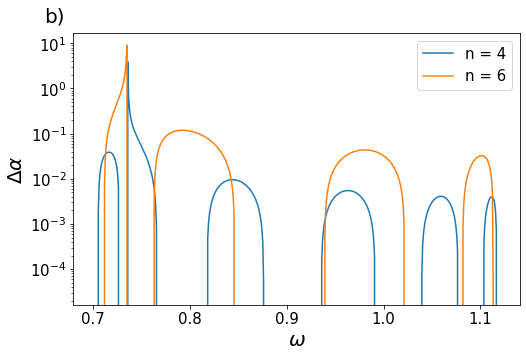

In [181]:
fig, ax = plt.subplots(figsize=(8,5))
ax = sns.lineplot(v_omega_new, dalpha4,  label = 'n = 4')
ax = sns.lineplot(v_omega_new, dalpha6, label = 'n = 6')
ax.set_yscale('log')
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend(fontsize = 15)
ax.set_xlabel(r'$\omega$', fontsize = 20),ax.set_ylabel(r'$\Delta \alpha$', fontsize =20)
ax.text(0.65,30,'b)',fontsize= 20)
plt.show()
fig.savefig("Polynomial_rel_err.pdf", bbox_inches = 'tight')

In [186]:
def compute_coefficients_Q(v_alpha,omega,n):
    """Determine coefficients of the rational approximating function."""
    exponents = np.arange(0,n+1)
    Omega = omega[:,na]**exponents
    Q = np.concatenate((Omega, -v_alpha[:,na]*Omega[:,1:]),axis = 1)
    return lsq(Q, v_alpha)

def rat_func(v_omega, c_coeff, n):
    exponents = np.arange(0,n+1)
    Omega = v_omega[:,na]**exponents
    Q_num = Omega@c_coeff[:n+1]
    Q_den = 1+Omega[:,1:]@c_coeff[n+1:]
    return Q_num/Q_den

In [187]:
c_coeff_2 = compute_coefficients_Q(v_alpha,v_omega,2)
Q_alpha_2 = rat_func(v_omega, c_coeff_2, 2)
Q_alpha_4 = rat_func(v_omega, compute_coefficients_Q(v_alpha,v_omega,4),4)
Q_2_error = (Q_alpha_2-v_alpha)/v_alpha
Q_4_error = (Q_alpha_4-v_alpha)/v_alpha

[]

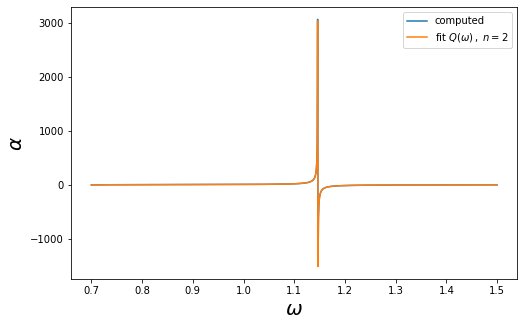

In [188]:
fig, ax = plt.subplots(figsize=(8,5))
ax = sns.lineplot(v_omega, v_alpha,label = 'computed')
ax = sns.lineplot(v_omega, Q_alpha_2, label = r'$\mathrm{fit}\ Q(\omega)\,,\ n = 2$')
ax.set_xlabel(r'$\omega$', fontsize = 20),ax.set_ylabel(r'$\alpha$', fontsize =20)
ax.plot()

[]

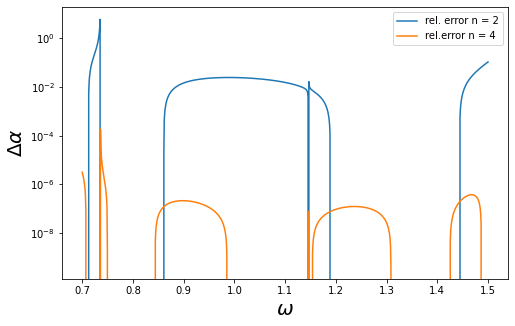

In [189]:
fig, ax = plt.subplots(figsize=(8,5))
ax = sns.lineplot(v_omega, Q_2_error,  label = 'rel. error n = 2')
ax = sns.lineplot(v_omega, Q_4_error, label = 'rel.error n = 4')
ax.set_yscale('log')
ax.set_xlabel(r'$\omega$', fontsize = 20),ax.set_ylabel(r'$\Delta \alpha$', fontsize =20)
ax.plot()